Example taken from: https://xeofs.readthedocs.io/en/latest/auto_examples/index.html

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from cartopy.crs import EqualEarth, PlateCarree

from xeofs.models import EOF, EOFRotator, ExtendedEOF

In [2]:
sst = xr.tutorial.open_dataset("ersstv5")["sst"]

In [3]:
fp = '../data/sst.mnmean.nc'
sst2 = xr.open_dataset(fp)

In [4]:
sst2['sst']

<xarray.DataArray 'sst' (time: 2038, lat: 89, lon: 180)>
[32648760 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-10-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [5]:
sst

<xarray.DataArray 'sst' (time: 624, lat: 89, lon: 180)>
[9996480 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [6]:
sst2['sst'][1000:]

<xarray.DataArray 'sst' (time: 1038, lat: 89, lon: 180)>
[16628760 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1937-05-01 1937-06-01 ... 2023-10-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [7]:
my_sst = sst2['sst'][1500:]

<br>
<br>

## Standard EOF analysis

In [8]:
model = EOF(n_modes=5, use_coslat=True)
model.fit(my_sst, dim="time")
expvar = model.explained_variance()
expvar_ratio = model.explained_variance_ratio()
components = model.components()
scores = model.scores()

In [9]:
print("Explained variance: ", expvar.round(0).values)
print("Relative: ", (expvar_ratio * 100).round(1).values)

Explained variance:  [24781.  1070.   686.   350.   309.]
Relative:  [85.9  3.7  2.4  1.2  1.1]


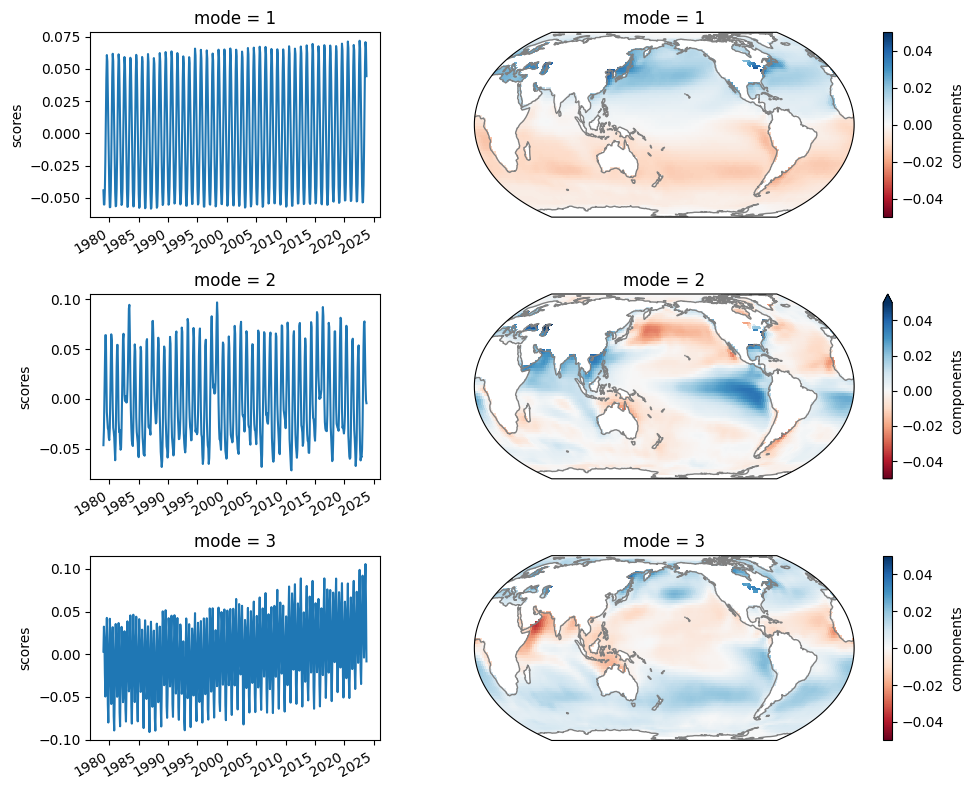

In [10]:
proj = EqualEarth(central_longitude=180)
kwargs = {"cmap": "RdBu", "vmin": -0.05, "vmax": 0.05, "transform": PlateCarree()}

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 2, width_ratios=[1, 2])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(3)]
ax1 = [fig.add_subplot(gs[i, 1], projection=proj) for i in range(3)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    scores.sel(mode=i + 1).plot(ax=a0)
    a1.coastlines(color=".5")
    components.sel(mode=i + 1).plot(ax=a1, **kwargs)

    a0.set_xlabel("")

plt.tight_layout()
# plt.savefig("eof-smode.jpg")

<br>
<br>

## EOF analysis with varimax rotation

In [11]:
model = EOF(n_modes=5, use_coslat=True)
model.fit(my_sst, dim="time")

rotator = EOFRotator(n_modes=5)
rotator.fit(model)
expvar = rotator.explained_variance()
expvar_ratio = rotator.explained_variance_ratio()
rcomponents = rotator.components()
rscores = rotator.scores()

In [12]:
print("Explained variance: ", expvar.round(0).values)
print("Relative: ", (expvar_ratio * 100).round(1).values)

Explained variance:  [19901.  5262.  1084.   502.   449.]
Relative:  [68.9 18.2  3.8  1.7  1.6]


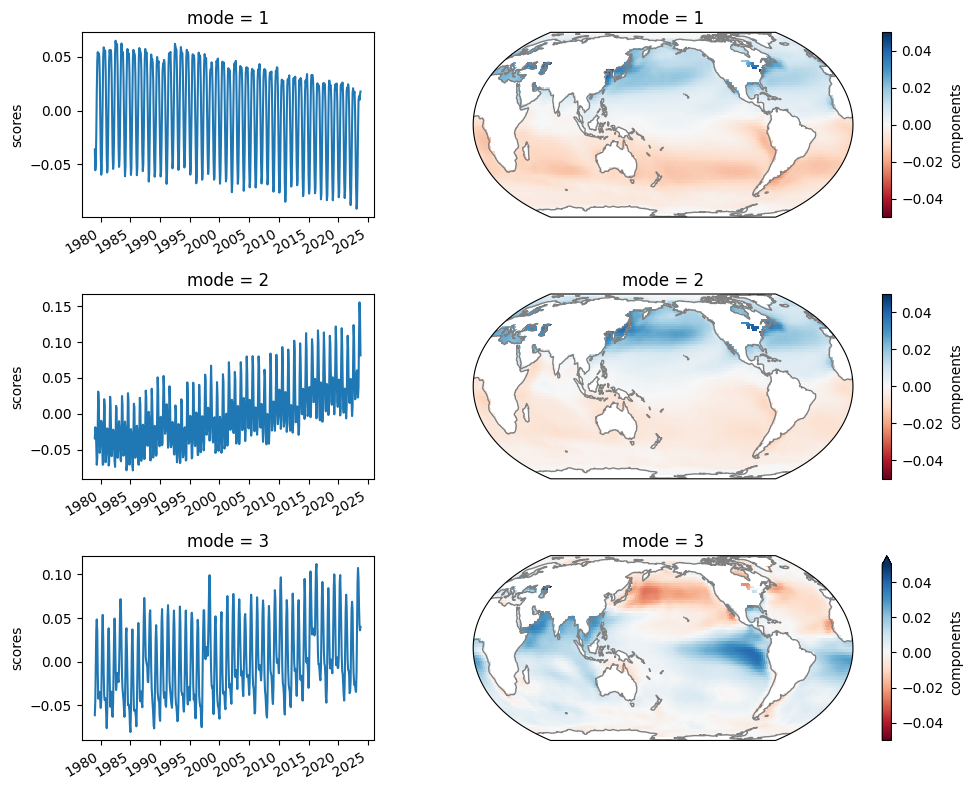

In [13]:
proj = EqualEarth(central_longitude=180)
kwargs = {"cmap": "RdBu", "vmin": -0.05, "vmax": 0.05, "transform": PlateCarree()}

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 2, width_ratios=[1, 2])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(3)]
ax1 = [fig.add_subplot(gs[i, 1], projection=proj) for i in range(3)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    rscores.sel(mode=i + 1).plot(ax=a0)
    a1.coastlines(color=".5")
    rcomponents.sel(mode=i + 1).plot(ax=a1, **kwargs)

    a0.set_xlabel("")

plt.tight_layout()
# plt.savefig("eof-smode.jpg")

<br>
<br>

# Remove seasonal cycle and nonlinear trends from data

In [14]:
my_sst = sst2['sst'][1500:]
my_sst = my_sst.groupby("time.month") - my_sst.groupby("time.month").mean("time")

In [15]:
eof = EOF(n_modes=10)
eof.fit(my_sst, dim="time")
scores = eof.scores()
components = eof.components()

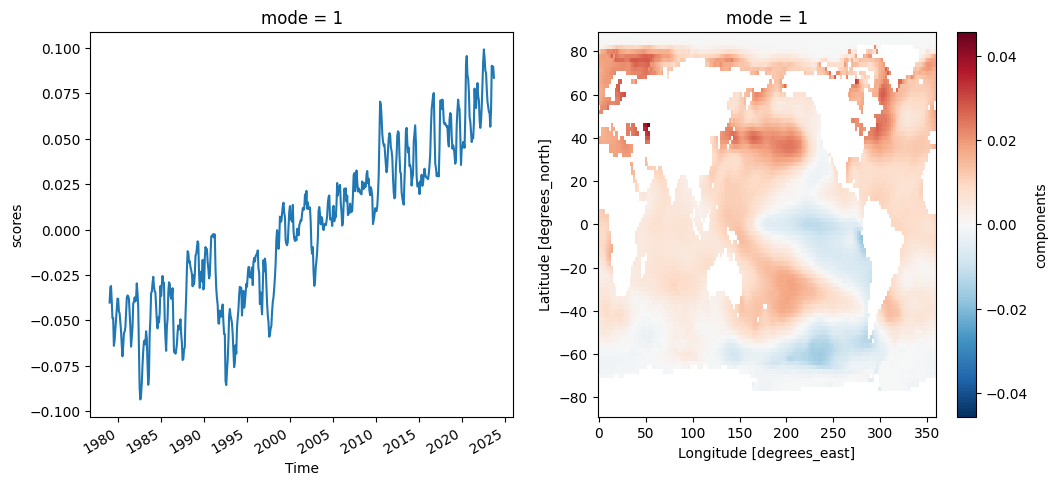

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
scores.sel(mode=1).plot(ax=ax[0])
components.sel(mode=1).plot(ax=ax[1])

In [17]:
eeof = ExtendedEOF(n_modes=5, tau=1, embedding=120, n_pca_modes=50)
eeof.fit(my_sst, dim="time")
components_ext = eeof.components()
scores_ext = eeof.scores()

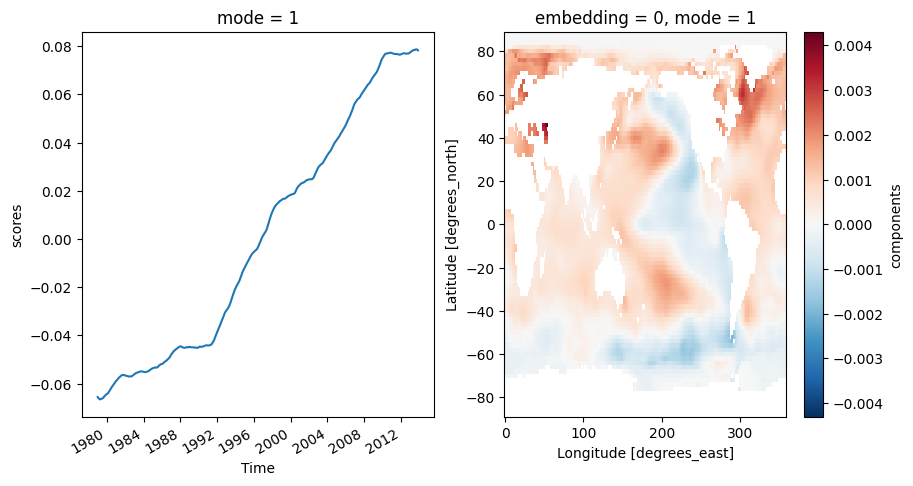

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
scores_ext.sel(mode=1).plot(ax=ax[0])
components_ext.sel(mode=1, embedding=0).plot(ax=ax[1])

In [19]:
sst_trends = eeof.inverse_transform(scores_ext.sel(mode=1))
sst_detrended = my_sst - sst_trends

In [20]:
eof_model_detrended = EOF(n_modes=5)
eof_model_detrended.fit(sst_detrended, dim="time")
scores_detrended = eof_model_detrended.scores()
components_detrended = eof_model_detrended.components()

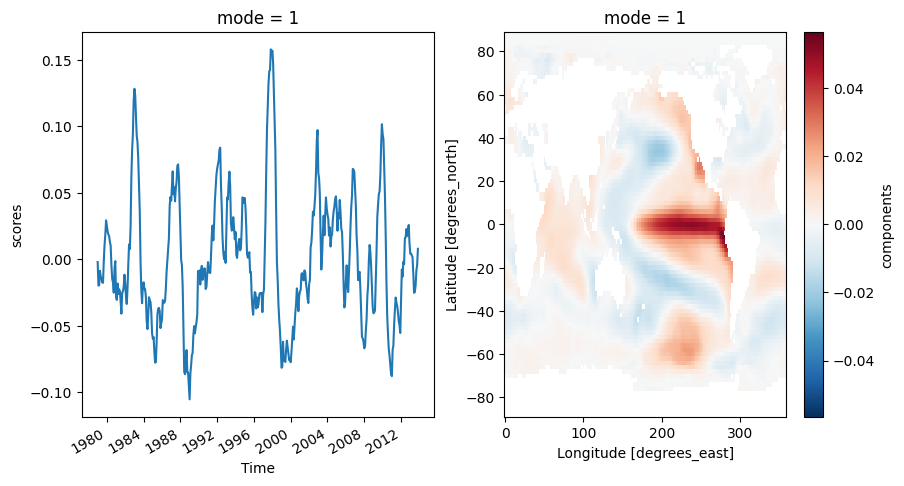

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
scores_detrended.sel(mode=1).plot(ax=ax[0])
components_detrended.sel(mode=1).plot(ax=ax[1])

Detrending with varimax rotation:

In [22]:
my_sst = sst2['sst'][1500:]
my_sst = my_sst.groupby("time.month") - my_sst.groupby("time.month").mean("time")

In [23]:
sst_trends = eeof.inverse_transform(scores_ext.sel(mode=1))
sst_detrended = my_sst - sst_trends

In [24]:
eof_model_detrended = EOF(n_modes=5)
eof_model_detrended.fit(sst_detrended, dim="time")

rotator = EOFRotator(n_modes=5)
rotator.fit(eof_model_detrended)
expvar = rotator.explained_variance()
expvar_ratio = rotator.explained_variance_ratio()
rcomponents = rotator.components()
rscores = rotator.scores()

In [25]:
print("Explained variance: ", expvar.round(0).values)
print("Relative: ", (expvar_ratio * 100).round(1).values)

Explained variance:  [340. 155. 126. 117. 115.]
Relative:  [12.8  5.8  4.8  4.4  4.3]


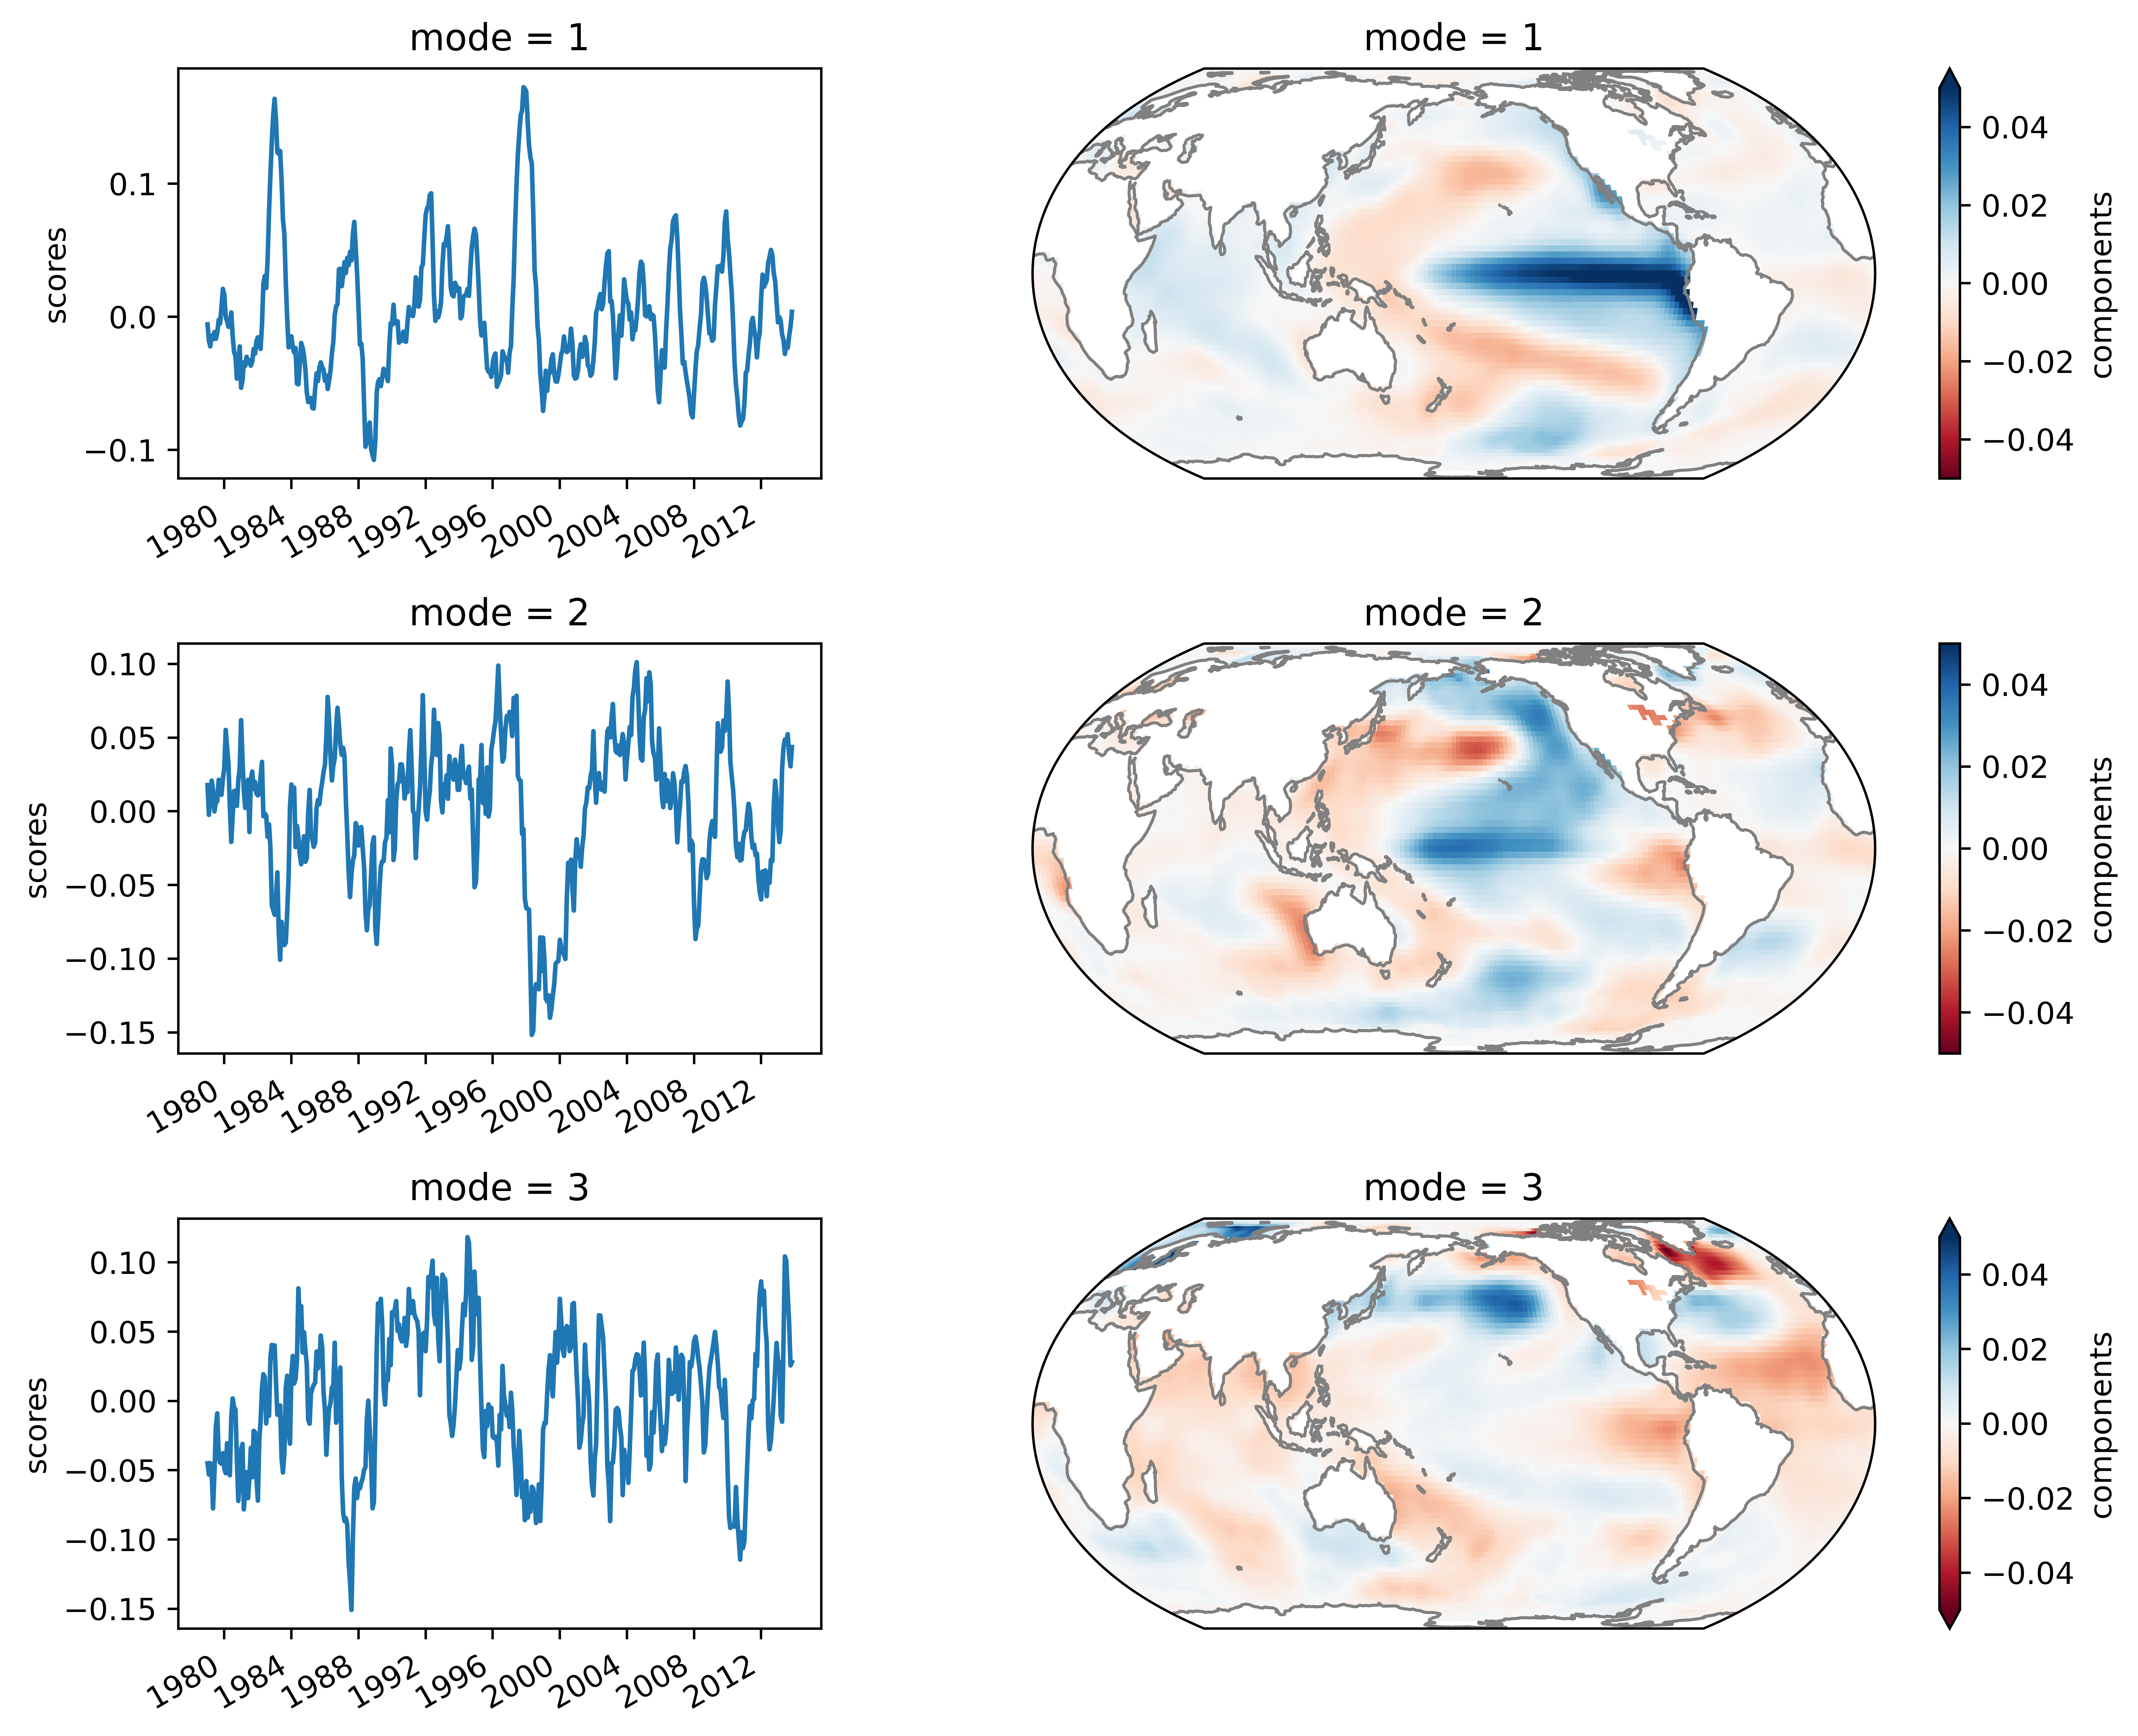

In [26]:
proj = EqualEarth(central_longitude=180)
kwargs = {"cmap": "RdBu", "vmin": -0.05, "vmax": 0.05, "transform": PlateCarree()}

fig = plt.figure(figsize=(10, 8), dpi=700)
gs = GridSpec(3, 2, width_ratios=[1, 2])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(3)]
ax1 = [fig.add_subplot(gs[i, 1], projection=proj) for i in range(3)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    rscores.sel(mode=i + 1).plot(ax=a0)
    a1.coastlines(color=".5")
    rcomponents.sel(mode=i + 1).plot(ax=a1, **kwargs)

    a0.set_xlabel("")

plt.tight_layout()
# plt.savefig("eof-smode.jpg")